In [ ]:
########## Block 1 ############## <-- Please refer this block number when you ask questions
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set("notebook")

# A useful plotting function that displays joint distribution of x and y, 
# and marginalized distribuitions of each.
# Not important
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y)
    ax1.hist(X, density=True)
    ax2.hist(Y, orientation='horizontal', density=True)
    ax.set_xlabel(nameX)
    ax.set_ylabel(nameY)

# Gaussian Process Example (30 mins)


## Gaussian Process (unconditioned)

An uncondititoned Gaussian Process can be viewed as a random function $G(x)$, specified by the mean (one-point function)
$$\langle G(x)\rangle \equiv \mu(x),$$ 
and covariance function (two-point function)
$$\langle\delta G(x) \delta G(x')\rangle \equiv k(x, x').$$
And we assume any combinations of the random variable $\{ G(x_1), G(x_2), \cdots, G(x_n)\}$ forms an $n$-dimensional Normal distribution with the above mean and pairwise covaraince.

**Let's examine a conceret example**

### Single and multi-variated Gaussian distribution

1. A single-variable Gaussian distribution is charactered by a mean $\mu$ and a standard deviation $\sigma$

$$f(x; \mu, \sigma) = \frac{1}{(2\pi)^{1/2}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

2. A multi-varaite Gaussian distribution is charactered by the means $\mu(x_1), \mu(x_2),\cdots$ of each variable and the covariance matrix:
$$ \Sigma = \begin{bmatrix} s_{11} & s_{12} & \cdots\\
s_{21} & s_{22} & \cdots\\ 
\cdots & \cdots & \cdots
\end{bmatrix}
$$
with $\sigma_{12}^2 <\sigma_{11} \sigma_{22}$


$$f(x_1, x_2; \mu_1, \mu_2, \Sigma_{ij}) = \frac{1}{(2\pi)^{1/2}\sqrt{|\Sigma|}} \exp\left\{-\frac{1}{2}\sum_{i,j=1}^2(x_i-\mu_i)^T \Sigma_{ij}^{-1} (x_j-\mu_j)\right\} $$

We will take a specific form of the kernel function 
$$k(x_1, x_2) = C^2 \exp\left\{-\frac{|x_1-x_2|^2}{2L^2}\right\}$$
**Output values of close input points $x_{1,2}$ have strongly correlated / close outputs $y_{1,2}$**

In [ ]:
########## Block 2 ##############

# The Gaussian-like two-point function for filling the elements of the covariance matrix
# cov(x1, x2) = C^2 exp(-(x1-x2)^2/(2L^2) )
# C: std of the distriubtion at one point
# L: correlation length scale
@np.vectorize
def kernel(x1, x2, C, L):
    return C**2 * np.exp(-.5*(x1-x2)**2/L**2)

# Function that samples N-D normal distribution 
# with x = [-1.0, ... N points ... 1.0]
#      mean = [0, ..., 0]
#      C_ij = Cov(x_i, x_j) = kernel(x_i, x_j; C, L)
# generate 1000 lines by default
def ND_Normal(N, C, L, nsamples=1000):
    x = np.linspace(-1,1,N)
    mean = np.zeros_like(x)
    cov = kernel(*np.meshgrid(x,x), C, L)
    return x, np.random.multivariate_normal(mean, cov, nsamples)

# Generate an ensemble of size-10 random vectors from a distribution with C=1 and L=1
x, Y = ND_Normal(N=10, C=1, L=1)

# Checkout the joint distribution of the ith and jth random varible
i, j = 3, 5
hist_1d_2d(Y[:,i], Y[:,j], '$x_{}$'.format(i), '$x_{}$'.format(j))
plt.title(r"$|x_i-x_j|/L = {:1.2f}$".format(np.abs(x[i]-x[j])/1))

# How does 

Another way to look at this multi-variate normal, plot $x$ and realizations $y$ as a scattered plot. Since close inputs gaurantees close outputs, the resulting plots are samples of smooth functions with the given variance and correlation function.

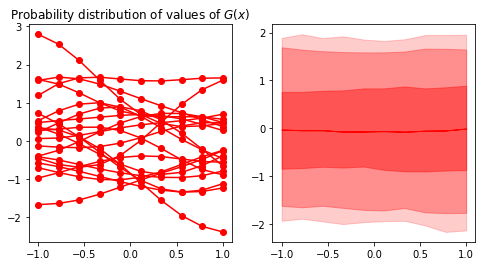

In [3]:
########## Block 3 ##############
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
_ = ax1.plot(x, Y[:20].T, 'ro-')
ax1.set_title("20 realizations of the rasndom function")

CLbins = [0,60,90,95]
ax1.set_title("Probability distribution of values of $G(x)$")
for CL, opacity in zip(CLbins, [1., .4, .3, .2, .1]):
    lower, upper = np.percentile(Y, [50-CL/2., 50+CL/2.], axis=0)
    ax2.fill_between(x, lower, upper, color='r', alpha=opacity)

### GP-1: Conditioning the GP
Now, we would like to pick a particular subset of random functions that comes near to the points
$$(x^*_i, y^*_i) =  (-1,-1), (0,0.5),(1,0.7)$$.
To do this, we picks random functions that statisfies $$|G(x^*_i)-y^*_i | < \epsilon$$

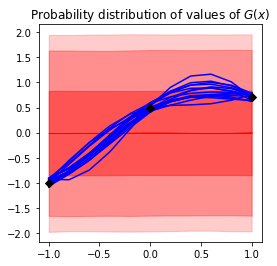

In [4]:
########## Block 4 ##############
x, Y = ND_Normal(N=11, C=1, L=1, nsamples=100000)
epsilon = 0.1
cut = ( np.abs(Y[:,0]+1)<epsilon ) \
    & ( np.abs(Y[:,5]-.5)<epsilon ) \
    & ( np.abs(Y[:,10]-.7)<epsilon ) \

fig, ax = plt.subplots(1,1, figsize=(4,4))
CLbins = [0,60,90,95]
ax.set_title("Probability distribution of values of $G(x)$")
for CL, opacity in zip(CLbins, [1., .4, .3, .2, .1]):
    lower, upper = np.percentile(Y, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(x, lower, upper, color='r', alpha=opacity)
ax.errorbar([-1,0,1],[-1,.5,.7],yerr=epsilon,fmt='kD')
_ = ax.plot(x, Y[cut].T,'b-')

The conditioned set of random functions provides an interpolation of the three conditioned points with their spread as uncertainties. The natural inclusion of interpolation uncertainty is a big advantage of GP in the workflow of Bayesian analysis of complex model.

### The variance and the correlations length $C^2, L$.
Strickly spearking, the variance and the correlation length is unknown for a given set of data to be interpolated. An common practice is to optimize the values of $C$ and $L$ in the "fitting" so that it maximumize the likelihood of desribing the data. The systematic tuning for an optimal set of $C$ and $L$ is the so-called training process.

For practical use, we can use well developed GP modules in sklearn. It implements different kinds of kernel functions and training algorithms.

https://scikit-learn.org/stable/tutorial/basic/tutorial.html

https://scikit-learn.org/stable/modules/gaussian_process.html

## Applying sklearn GP to 1D inference/interpolation

**The problem**: given values of function $F(x)$ on a sparse grid $x_i, i=1,2,\cdots$, use Gaussain process emulator (regressor) to infer the functional form of the $F$.

$$F(x) = x^2 + \sin(5x)$$

Text(0, 0.5, '$y$')

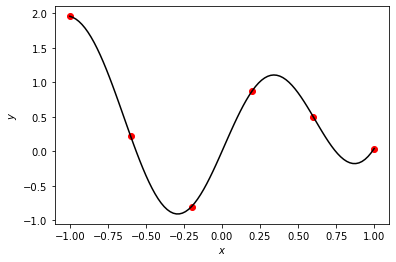

In [5]:
########## Block 5 ##############
# This is function to be emualted
def F(x):
    return x**2+np.sin(5*x)

x_design = np.linspace(-1,1,6)
y_design = F(x_design)
plt.plot(x_design, y_design, 'ro', label='Design')
x = np.linspace(-1,1,101)
plt.plot(x, F(x),'k-', label=r'$F(x)$')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [6]:
########## Block 6 ##############
from sklearn.gaussian_process import \
     GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

# Train the emulator, specify the kernel functions 
kernel = \
    1 * kernels.RBF(
        length_scale=1.,
        length_scale_bounds=(.1,10)
    )

gp = GPR(kernel=kernel, n_restarts_optimizer=5)
gp.fit(np.atleast_2d(x_design).T, y_design)
print("C^2 = ", gp.kernel_.get_params()['k1'])
print(gp.kernel_.get_params()['k2'])
print("This score of describing the training data:", gp.score(np.atleast_2d(x_design).T, y_design))

xv = np.linspace(-1,1,11)
print("This score of describing validation data:", gp.score(np.atleast_2d(xv).T, F(xv)) )


C^2 =  1.05**2
RBF(length_scale=0.315)
This score of describing the training data: 1.0
This score of describing validation data: 0.988931140573504


In [7]:
########## Block 7 ##############
# A wrapper to make predictions from GP
def predict(x, gp):
    mean, cov = gp.predict(return_cov=True, X=np.atleast_2d(x).T)
    return mean, np.sqrt(np.diag(cov))

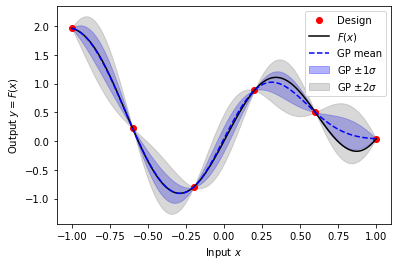

In [8]:
########## Block 8 ##############
x = np.linspace(-1,1,101)
y, ystd = predict(x, gp)

plt.plot(x_design, y_design, 'ro', label='Design')
plt.plot(x, F(x),'k-', label=r'$F(x)$')
plt.plot(x, y,'b--', label=r'GP mean')
plt.fill_between(x, y-ystd, y+ystd, color='b', alpha=.3, label=r'GP $\pm 1\sigma$')
plt.fill_between(x, y-2*ystd, y+2*ystd, color='gray', alpha=.3, label=r'GP $\pm 2\sigma$')
plt.xlabel(r"Input $x$")
plt.ylabel(r"Output $y=F(x)$")
plt.legend()

    Go back to make the prediction range of $x$ larger, `[-2,2]` for instance. Does this Gaussian provide good extrapolation? (However, it is possible to use GP to make projections)

## A 2D example

In [93]:
@np.vectorize
def Ftruth(x, y):
    return np.sin(x*y*4-x**2*4)
xfine = np.linspace(0,1,101)
Xfine, Yfine = np.meshgrid(xfine, xfine)
Xfine = Xfine.T
Yfine = Yfine.T
Zfine = Ftruth(Xfine, Yfine)

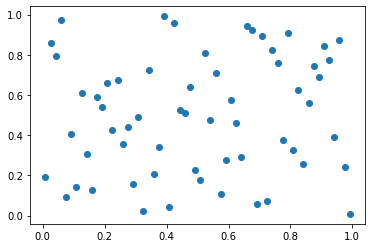

In [118]:
# Generate some random training data within [0,1]^2
from pyDOE import lhs
Xdesign = lhs(2,60, criterion="centermaximin")
Ydesign = Ftruth(*Xdesign.T)
plt.scatter(*Xdesign.T)

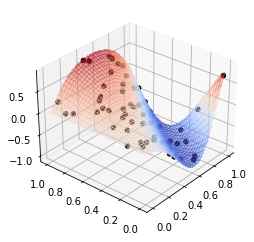

In [119]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d',)
ax.view_init(30,220)
ax.plot_surface(Xfine, Yfine, Zfine, cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=.4)
ax.scatter(*Xdesign.T, Ydesign, color='k', alpha=1)

In [120]:
# Train GP
kernel = \
    1 * kernels.RBF(
        length_scale=(1., 1.),
        length_scale_bounds=[(.01,100), (.01,100)]
    )

gp2d = GPR(kernel=kernel, n_restarts_optimizer=5)
gp2d.fit(np.atleast_2d(Xdesign), Ydesign)
print("C^2 = ", gp.kernel_.get_params()['k1'])
print(gp.kernel_.get_params()['k2'])


C^2 =  1.05**2
RBF(length_scale=0.315)


In [121]:
Zpredict = []
Zstd =  []
for ix, iy in zip(Xfine.flatten(), Yfine.flatten()):
    mean, cov = gp2d.predict(return_cov=True, X=np.atleast_2d([ix, iy]))
    Zpredict.append(mean[0])
    Zstd.append(cov[0]**.5)
Zpredict = np.array(Zpredict).reshape(*Xfine.shape)
Zstd = np.array(Zstd).reshape(*Xfine.shape)

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error two minor releases later


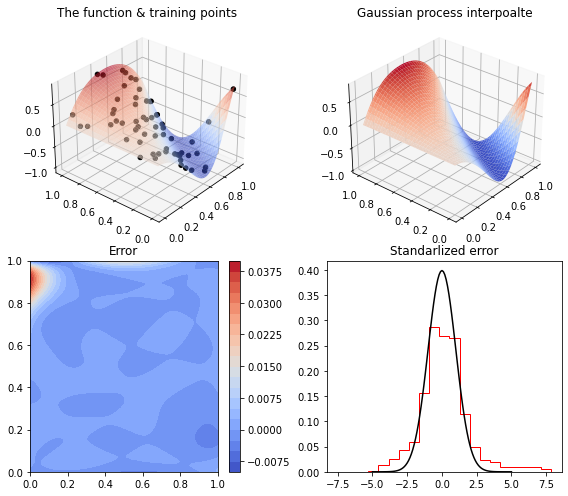

In [127]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(221, projection='3d')
ax.view_init(30,220)
ax.plot_surface(Xfine, Yfine, Zfine,  cmap=plt.cm.coolwarm, linewidth=0, alpha=.6)
ax.scatter(*Xdesign.T, Ydesign, color='k', alpha=1)
ax.set_title("The function & training points")

ax = fig.add_subplot(222, projection='3d')
ax.view_init(30,220)
ax.plot_surface(Xfine, Yfine, Zpredict, cmap=plt.cm.coolwarm, linewidth=0, alpha=1)
ax.set_title("Gaussian process interpoalte")

ax = fig.add_subplot(223)
diff = (Zfine-Zpredict)
H = ax.contourf(Xfine, Yfine, diff.T, 20, cmap=plt.cm.coolwarm)
plt.colorbar(H)
ax.set_title("Error")

ax = fig.add_subplot(224)
diff_scaled = (Zfine-Zpredict)/Zstd
ax.hist(diff_scaled.flatten(), bins=21, density=True, histtype='step', color='r', lw=1)
ax.set_title("Standarlized error")

s = np.linspace(-5,5,101)
ax.plot(s, np.exp(-s**2/2)/np.sqrt(2*np.pi),'k-')

plt.tight_layout()
plt.savefig("Emulator_demo-2d.png", dpi=300, Transparent=True)